<a href="https://colab.research.google.com/github/Tripaloski1212/Mi-primer-repositorio/blob/main/Proyecto_Planta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 🌿 Iniciando Simulación de Crecimiento de Plantas ---
--- Simulación finalizada después de 90 días. ---

Resultados exportados a: simulacion_crecimiento_resultados.csv

--- Vista Previa de los Resultados (Primeros 5 días) ---
   Día  GDD_Acumulado   Tmax   Tmin  Altura (cm)  LAI (m2/m2)  \
0    1           6.93  15.63  14.22         5.44         0.09   
1    2          16.25  28.07   6.58         8.70         0.19   
2    3          20.36  16.43   7.79        10.50         0.25   
3    4          23.38  16.33   5.71        11.96         0.31   
4    5          30.18  23.54   6.06        15.71         0.45   

   Luz_Interceptada (f)  ET_Diaria (mm)                            BBCH  
0                  0.05            0.08  10 - Emergencia/Inicio de Hoja  
1                  0.11            0.22  10 - Emergencia/Inicio de Hoja  
2                  0.14            0.20  10 - Emergencia/Inicio de Hoja  
3                  0.17            0.30  10 - Emergencia/Inicio de Hoja  
4         

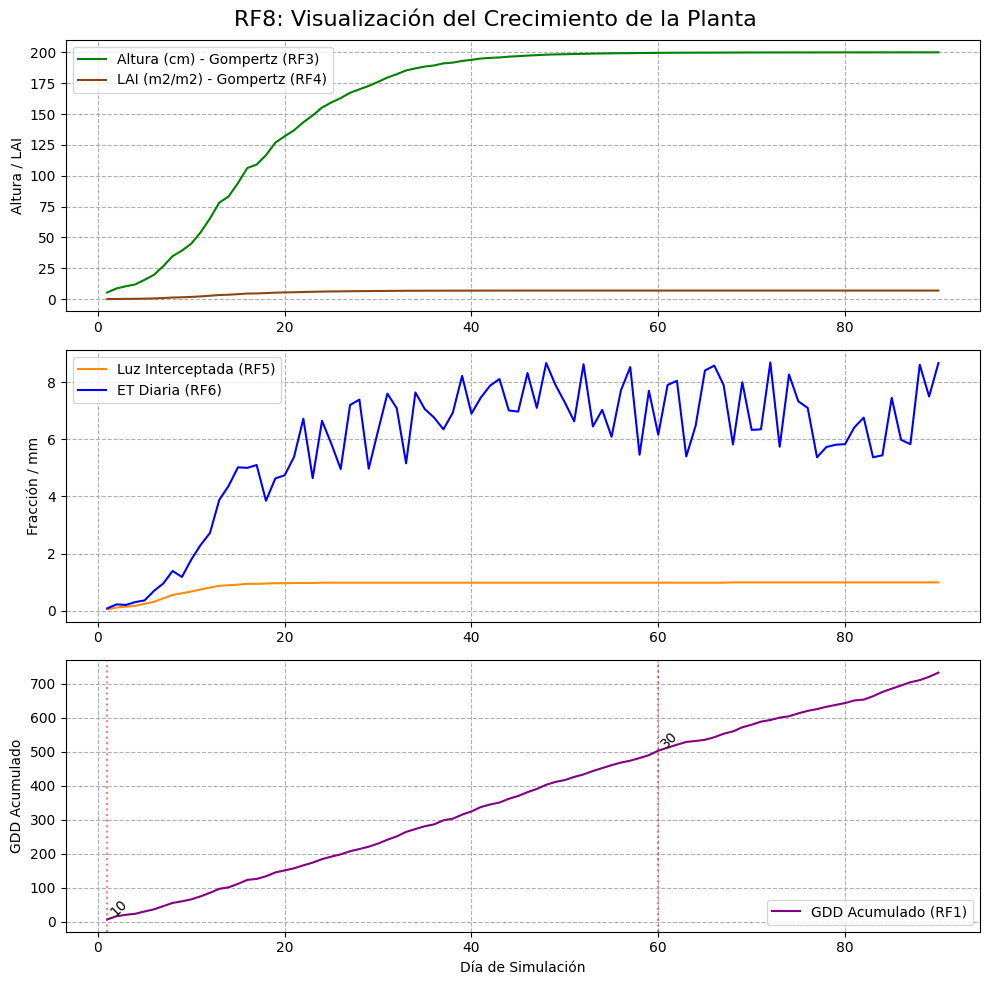

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================================
# 1. MÓDULO DE CONFIGURACIÓN Y DATOS (RF9)
# ==============================================================================

# Parámetros configurables por el usuario (RF9)
CONFIGURACION_SIMULADOR = {
    # RF9: Parámetros del modelo (Gompertz para RF3 y RF4)
    'GOMPERTZ_ESTRUCTURAL': {
        'A': 200.0,  # Asintota Máxima para Altura (cm)
        'b': 4.0,    # Parámetro de forma (inversamente proporcional a la altura inicial)
        'k': 0.015,  # Tasa de crecimiento (por GDD)
    },
    'GOMPERTZ_FOLIAR': {
        'A': 7.0,    # Asintota Máxima para LAI (m2/m2)
        'b': 5.0,    # Parámetro de forma
        'k': 0.02,   # Tasa de crecimiento (por GDD)
    },
    # RF9: Parámetros Agronómicos y Físicos
    'T_BASE': 8.0,       # Temperatura Base para GDD (°C)
    'K_EXTINCION': 0.6,  # Coeficiente de extinción de luz 'k' (Ley de Beer-Lambert)

    # Simulación de datos meteorológicos (RF9)
    'DIAS_SIMULACION': 90,
    'DATOS_METEOROLOGICOS': pd.DataFrame({
        'Tmax': np.random.uniform(15, 30, 90), # T° Máxima diaria simulada
        'Tmin': np.random.uniform(5, 15, 90),  # T° Mínima diaria simulada
        'Radiacion': np.random.uniform(15, 25, 90) # Radiación solar (MJ/m2/día), necesaria para RF6 y RF5
    })
}

# Rangos simplificados de BBCH (RF2)
RANGOS_BBCH = {
    (0, 500): "10 - Emergencia/Inicio de Hoja",
    (501, 1200): "30 - Desarrollo de Tallo/Macollamiento",
    (1201, 2000): "60 - Floración/Antesis",
    (2001, 3000): "70 - Desarrollo de Fruto/Maduración"
}

# ==============================================================================
# 2. MÓDULO DE MODELOS MATEMÁTICOS Y BIOLÓGICOS (RF1, RF3, RF4, RF5, RF2)
# ==============================================================================

def calcular_GDD_diario(Tmax, Tmin, Tbase):
    """RF1. Calcula los Grados-Día diarios."""
    T_promedio = (Tmax + Tmin) / 2
    GDD_diario = max(0, T_promedio - Tbase)
    return GDD_diario

def gompertz(GDD_acumulado, A, b, k):
    """RF3 y RF4. Modelo de crecimiento Gompertz (función sigmoide asimétrica)."""
    # A: Asintota (valor máximo)
    # b: Posición del punto de inflexión
    # k: Tasa de crecimiento
    return A * np.exp(-b * np.exp(-k * GDD_acumulado))

def intercepcion_luz(LAI, k_extincion):
    """RF5. Estima la fracción de luz interceptada (f) por el dosel (Ley de Beer-Lambert)."""
    # f = 1 - (I / I0) = 1 - exp(-k * LAI)
    return 1 - np.exp(-k_extincion * LAI)

def asignar_BBCH(GDD_acumulado):
    """RF2. Asigna un estadio fenológico BBCH basado en GDD."""
    for (min_gdd, max_gdd), estadio in RANGOS_BBCH.items():
        if min_gdd <= GDD_acumulado <= max_gdd:
            return estadio
    if GDD_acumulado > max(RANGOS_BBCH.keys())[1]:
        return "90 - Senescencia/Cosecha"
    return "00 - Germinación"

# Nota: El RF6 (Penman-Monteith) es complejo y se simula aquí con un placeholder simple.
def calcular_ET_placeholder(radiacion, LAI):
    """RF6 Placeholder. Simula la ET en función de la radiación y la intercepción de luz."""
    # La ET real depende de muchos factores (viento, humedad, T°).
    # Aquí se simula como proporcional a la radiación y al LAI (biomasa evapotranspirante).
    eficiencia_uso_agua = 0.05
    et_simulada = eficiencia_uso_agua * radiacion * LAI
    return max(0.0, et_simulada)

# ==============================================================================
# 3. CLASE DE ESTADO DE LA PLANTA (RF7)
# ==============================================================================

class Planta:
    """Clase que mantiene el estado actual de la planta y sus parámetros."""
    def __init__(self, config):
        # Parámetros de configuración
        self.Tbase = config['T_BASE']
        self.k_extincion = config['K_EXTINCION']
        self.param_estructural = config['GOMPERTZ_ESTRUCTURAL']
        self.param_foliar = config['GOMPERTZ_FOLIAR']

        # Variables de estado (se inician en 0)
        self.dia = 0
        self.GDD_acumulado = 0.0
        self.LAI = 0.0
        self.altura = 0.0
        self.luz_interceptada = 0.0
        self.ET_diaria = 0.0
        self.BBCH = asignar_BBCH(self.GDD_acumulado)

    def actualizar_crecimiento_diario(self, GDD_diario, radiacion_diaria):
        """RF7. Actualiza todas las variables de crecimiento y estado."""
        self.dia += 1
        self.GDD_acumulado += GDD_diario

        # 1. Crecimiento Estructural (RF3 - Ahora Gompertz)
        p_est = self.param_estructural
        self.altura = gompertz(self.GDD_acumulado, p_est['A'], p_est['b'], p_est['k'])

        # 2. Desarrollo Foliar (RF4 - Gompertz)
        p_fol = self.param_foliar
        self.LAI = gompertz(self.GDD_acumulado, p_fol['A'], p_fol['b'], p_fol['k'])

        # 3. Intercepción de Luz (RF5 - Beer-Lambert)
        self.luz_interceptada = intercepcion_luz(self.LAI, self.k_extincion)

        # 4. Asignación BBCH (RF2)
        self.BBCH = asignar_BBCH(self.GDD_acumulado)

        # 5. Cálculo ET (RF6 - Placeholder)
        self.ET_diaria = calcular_ET_placeholder(radiacion_diaria, self.LAI)

# ==============================================================================
# 4. FUNCIÓN PRINCIPAL DE SIMULACIÓN (RF7, RF8, RF10)
# ==============================================================================

def ejecutar_simulacion():
    """RF7. Ejecuta el bucle de simulación día por día."""
    print("--- 🌿 Iniciando Simulación de Crecimiento de Plantas ---")

    config = CONFIGURACION_SIMULADOR
    datos_met = config['DATOS_METEOROLOGICOS']
    mi_planta = Planta(config)

    resultados = [] # Lista para almacenar el registro de datos (RF10)

    # Bucle de simulación día a día (RF7)
    for index, dia_data in datos_met.iterrows():
        # 1. Cálculo GDD (RF1)
        GDD_diario = calcular_GDD_diario(dia_data['Tmax'], dia_data['Tmin'], mi_planta.Tbase)

        # 2. Actualizar estado (RF7)
        mi_planta.actualizar_crecimiento_diario(GDD_diario, dia_data['Radiacion'])

        # 3. Guardar registro (RF10)
        registro = {
            'Día': mi_planta.dia,
            'GDD_Acumulado': round(mi_planta.GDD_acumulado, 2),
            'Tmax': round(dia_data['Tmax'], 2),
            'Tmin': round(dia_data['Tmin'], 2),
            'Altura (cm)': round(mi_planta.altura, 2),
            'LAI (m2/m2)': round(mi_planta.LAI, 2),
            'Luz_Interceptada (f)': round(mi_planta.luz_interceptada, 2),
            'ET_Diaria (mm)': round(mi_planta.ET_diaria, 2),
            'BBCH': mi_planta.BBCH
        }
        resultados.append(registro)

    print(f"--- Simulación finalizada después de {mi_planta.dia} días. ---")

    # 4. Procesar y Exportar Resultados (RF10)
    df_resultados = pd.DataFrame(resultados)
    nombre_archivo = 'simulacion_crecimiento_resultados.csv'
    df_resultados.to_csv(nombre_archivo, index=False)
    print(f"\nResultados exportados a: {nombre_archivo}")
    print("\n--- Vista Previa de los Resultados (Primeros 5 días) ---")
    print(df_resultados.head())

    # 5. Visualización (RF8)
    visualizar_resultados(df_resultados)

def visualizar_resultados(df):
    """RF8. Muestra gráficos de las variables de crecimiento."""
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    fig.suptitle('RF8: Visualización del Crecimiento de la Planta', fontsize=16)

    # Gráfico 1: Crecimiento Estructural (Altura) y Foliar (LAI)
    axs[0].plot(df['Día'], df['Altura (cm)'], label='Altura (cm) - Gompertz (RF3)', color='green')
    axs[0].plot(df['Día'], df['LAI (m2/m2)'], label='LAI (m2/m2) - Gompertz (RF4)', color='saddlebrown')
    axs[0].set_ylabel('Altura / LAI')
    axs[0].grid(True, linestyle='--')
    axs[0].legend()
    #

    # Gráfico 2: Variables Auxiliares (Luz Interceptada y ET)
    axs[1].plot(df['Día'], df['Luz_Interceptada (f)'], label='Luz Interceptada (RF5)', color='darkorange')
    axs[1].plot(df['Día'], df['ET_Diaria (mm)'], label='ET Diaria (RF6)', color='blue')
    axs[1].set_ylabel('Fracción / mm')
    axs[1].grid(True, linestyle='--')
    axs[1].legend()

    # Gráfico 3: GDD y Estadios BBCH (RF1 y RF2)
    axs[2].plot(df['Día'], df['GDD_Acumulado'], label='GDD Acumulado (RF1)', color='purple')

    # Añadir anotaciones de BBCH
    bbch_labels = df.drop_duplicates(subset=['BBCH'])
    for i, row in bbch_labels.iterrows():
        axs[2].axvline(x=row['Día'], color='r', linestyle=':', alpha=0.5)
        axs[2].text(row['Día'], row['GDD_Acumulado'], row['BBCH'].split(' ')[0], rotation=45, verticalalignment='bottom')

    axs[2].set_xlabel('Día de Simulación')
    axs[2].set_ylabel('GDD Acumulado')
    axs[2].grid(True, linestyle='--')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Ejecución del programa
if __name__ == "__main__":
    ejecutar_simulacion()